## Klassifikation viraler Gene in zeitliche Expressionsphasen

In diesem Schritt werden alle verfügbaren RNA-Seq-Datensätze von Phagen analysiert, um jedem Gen ein zeitliches Expressions-Label zuzuweisen:  
**`early`**, **`middle`**, **`late`** oder **`unknown`**.

Die Klassifikation basiert auf den mittleren Expressionswerten über verschiedene Zeitpunkte hinweg.  
Je nach Anzahl verfügbarer Zeitpunkte wird unterschiedlich vorgegangen:

- **≥ 3 Zeitpunkte** → automatische Aufteilung in drei Phasen (jeweils ein Drittel): `early`, `middle`, `late`
- **2 Zeitpunkte** → Zuordnung zu `early` oder `late`
- **1 Zeitpunkt** → keine sinnvolle Klassifikation möglich → `unknown`

**Ziel:** Erstellung eines gelabelten Datensatzes zur weiteren Analyse, z. B. für maschinelles Lernen, Expressionsvergleiche oder Visualisierungen von Transkriptionsverläufen.

In [92]:
# === Bibliotheken einbinden ===
import pandas as pd
import os
import re

# === Funktion zur Gen-Klassifikation ===
def classify_expression_with_fallback(file_path):
    """
    Klassifiziert Gene basierend auf Expressionswerten zu unterschiedlichen Zeitpunkten
    in die Phasen: 'early', 'middle' oder 'late'.

    Die Zeitpunkte werden aus den Spaltennamen extrahiert und in Drittel unterteilt.
    """

    # Lese TSV-Datei ein (tabulatorgetrennt)
    df = pd.read_csv(file_path, sep='\t')
    
    # Nur phagen gene auswählen
    phage_genes = df[df['Entity'] == 'phage']

    # Erkenne und gruppiere Zeitspalten nach Zeitpunkten (z.B. "10_R1" → 10.0)
    timepoint_cols = {}
    for col in phage_genes.columns:
        match_r = re.match(r'^(\d+\.?\d*)_R\d+$', col)  # z.B. "10_R1"
        match_simple = re.match(r'^(\d+\.?\d*)$', col)  # z.B. "10"
        if match_r:
            time = float(match_r.group(1))
            timepoint_cols.setdefault(time, []).append(col)
        elif match_simple:
            time = float(match_simple.group(1))
            timepoint_cols.setdefault(time, []).append(col)

    # Sortiere Zeitpunkte
    sorted_times = sorted(timepoint_cols.keys())
    n = len(sorted_times)

    # Fall 1: keine Zeitpunkte erkannt
    if n == 0:
        raise ValueError("Keine gültigen Zeitpunkte gefunden.")

    # Fall 2: nur ein Zeitpunkt – Klassifikation nicht möglich
    elif n == 1:
        phage_genes['Label'] = 'unknown'

    # Fall 3: zwei Zeitpunkte – teile in 'early' und 'late'
    elif n == 2:
        early, late = sorted_times
        phage_genes['mean_early'] = phage_genes[timepoint_cols[early]].mean(axis=1)
        phage_genes['mean_late'] = phage_genes[timepoint_cols[late]].mean(axis=1)
        phage_genes['Label'] = phage_genes[['mean_early', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    # Fall 4: drei oder mehr Zeitpunkte – unterteile in Drittel: early, middle, late
    else:
        early = sorted_times[:n // 3]
        middle = sorted_times[n // 3:2 * n // 3]
        late = sorted_times[2 * n // 3:]

        early_cols = [col for t in early for col in timepoint_cols[t]]
        middle_cols = [col for t in middle for col in timepoint_cols[t]]
        late_cols = [col for t in late for col in timepoint_cols[t]]

        phage_genes['mean_early'] = phage_genes[early_cols].mean(axis=1)
        phage_genes['mean_middle'] = phage_genes[middle_cols].mean(axis=1)
        phage_genes['mean_late'] = phage_genes[late_cols].mean(axis=1)

        # Bestimme die Phase mit der höchsten mittleren Expression
        phage_genes['Label'] = phage_genes[['mean_early', 'mean_middle', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    # Rückgabe der wichtigsten Spalten mit Label
    return phage_genes[['Geneid', 'Entity', 'Symbol', 'Label']]

# === Verzeichnis mit den TSV-Dateien ===
data_folder = "../data/normalized_data_bb/"
all_results = []

# === Schleife: Alle .tsv-Dateien im Verzeichnis verarbeiten ===
for file_name in os.listdir(data_folder):
    if file_name.endswith(".tsv"):
        file_path = os.path.join(data_folder, file_name)
        print(f"Verarbeite Datei: {file_name}")
        try:
            result = classify_expression_with_fallback(file_path)
            result['SourceFile'] = file_name  # Zurückverfolgbarkeit der Quelle
            all_results.append(result)
        except Exception as e:
            print(f"Fehler bei Datei {file_name}: {e}")

Verarbeite Datei: Brandao_LB_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Ceyssens_non-directional_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Guegler_T7_minusToxIN_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Leskinen_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Li_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned_TPM.tsv
Verarbeite Datei: Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv


C:\Users\decha\AppData\Local\Temp\ipykernel_16152\987676652.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes['mean_early'] = phage_genes[early_cols].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\987676652.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes['mean_middle'] = phage_genes[middle_cols].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\987676652.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Klassifikation mit paper-spezifischen Zeitfenstern

In diesem Schritt erfolgt die Klassifikation der Gene nicht mathematisch, sondern basierend auf den biologisch oder experimentell festgelegten Zeitphasen aus den Originalpublikationen.

Für jedes Paper sind konkrete Zeitfenster definiert, die die Phasen **early**, **middle** und **late** beschreiben. Diese Zeitfenster werden genutzt, um Gene anhand ihrer mittleren Expressionsstärke in die entsprechende Phase einzuordnen.

**Ziel:** Eine biologisch fundierte Klassifikation zur besseren Vergleichbarkeit mit den Aussagen der Studien.


In [93]:
import pandas as pd
import os
import re

# === Zeitfenster pro Paper (in Minuten) ===
# Diese Werte stammen direkt aus den jeweiligen Publikationen
paper_time_windows = {
    "brandao": [(0, 5, "early"), (5, 10, "middle"), (10, 15, "late")],
    "ceyssens": [(0, 5, "early"), (5, 15, "middle"), (15, 35, "late")],
    "guegler": [(2.5, 5, "early"), (5, 10, "middle"), (10, 20, "late")],
    "leskinen": [(2, 5, "early"), (10, 21, "middle"), (28, 49, "late")],
    "li": [(0, 45, "early"), (45, 75, "middle"), (75, 135, "late")],
    "sprenger": [(0, 15, "early"), (15, 60, "middle"), (60, 120, "late")],
    "wolfram-schauerte": [(0, 5, "early"), (5, 10, "middle"), (10, 20, "late")]
}

# === Hauptfunktion zur Klassifikation mit biologisch definierten Zeiträumen ===
def classify_expression_paper_defined(file_path, paper_key):
    """
    Klassifiziert Gene in early/middle/late basierend auf
    paper-spezifischen Zeitfenstern (biologische Definition).
    """
    df = pd.read_csv(file_path, sep="\t")
    
    # Nur phagen gene auswählen
    phage_genes = df[df['Entity'] == 'phage']
    
    time_windows = paper_time_windows.get(paper_key)

    if time_windows is None:
        raise ValueError(f"Kein Zeitfenster für Paper '{paper_key}' definiert.")

    # Zeitspalten erkennen (z. B. "10_R1" oder "10")
    timepoint_cols = {}
    for col in phage_genes.columns:
        match_r = re.match(r'^(\d+\.?\d*)_R\d+$', col)
        match_simple = re.match(r'^(\d+\.?\d*)$', col)
        if match_r:
            time = float(match_r.group(1))
            timepoint_cols.setdefault(time, []).append(col)
        elif match_simple:
            time = float(match_simple.group(1))
            timepoint_cols.setdefault(time, []).append(col)

    # Zeitpunkte den biologisch definierten Phasen zuordnen
    window_columns = {"early": [], "middle": [], "late": []}
    for time, cols in timepoint_cols.items():
        for start, end, label in time_windows:
            if start <= time < end:
                window_columns[label].extend(cols)
                break

    # Mittelwert pro Phase berechnen (falls Spalten vorhanden)
    for label in ["early", "middle", "late"]:
        if window_columns[label]:
            phage_genes[f"mean_{label}"] = phage_genes[window_columns[label]].mean(axis=1)

    # Bestimme für jedes Gen die Phase mit der höchsten mittleren Expression
    phage_genes["Label"] = phage_genes[[f"mean_{l}" for l in window_columns if window_columns[l]]].idxmax(axis=1).str.replace("mean_", "")

    return phage_genes[['Geneid', 'Entity', 'Symbol', 'Label']]

# === Paper-Key automatisch aus dem Dateinamen ableiten ===
def infer_paper_key_from_filename(filename):
    """
    Ermittelt anhand des Dateinamens den passenden Paper-Schlüssel.
    """
    name = filename.lower()
    for key in paper_time_windows:
        if key in name:
            return key
    return None

# === Verzeichnis mit Daten ===
data_folder = "../data/normalized_data_bb/"
all_results_paper_defined = []

# === Schleife: Alle Dateien verarbeiten ===
for file_name in os.listdir(data_folder):
    if file_name.endswith(".tsv"):
        paper_key = infer_paper_key_from_filename(file_name)
        if paper_key:
            file_path = os.path.join(data_folder, file_name)
            print(f"Verarbeite Datei: {file_name} ({paper_key})")
            try:
                result = classify_expression_paper_defined(file_path, paper_key)
                result['SourceFile'] = file_name  # für spätere Zuordnung
                all_results_paper_defined.append(result)
            except Exception as e:
                print(f"Fehler bei Datei {file_name}: {e}")
        else:
            print(f"Kein paper_key gefunden für Datei: {file_name}")


C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes[f"mean_{label}"] = phage_genes[window_columns[label]].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes[f"mean_{label}"] = phage_genes[window_columns[label]].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a 

Verarbeite Datei: Brandao_LB_full_raw_counts_cleaned_TPM.tsv (brandao)
Verarbeite Datei: Ceyssens_non-directional_full_raw_counts_cleaned_TPM.tsv (ceyssens)
Verarbeite Datei: Guegler_T7_minusToxIN_full_raw_counts_cleaned_TPM.tsv (guegler)
Verarbeite Datei: Leskinen_full_raw_counts_cleaned_TPM.tsv (leskinen)
Verarbeite Datei: Li_full_raw_counts_cleaned_TPM.tsv (li)
Verarbeite Datei: Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned_TPM.tsv (sprenger)
Verarbeite Datei: Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv (wolfram-schauerte)


C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes[f"mean_{label}"] = phage_genes[window_columns[label]].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phage_genes[f"mean_{label}"] = phage_genes[window_columns[label]].mean(axis=1)
C:\Users\decha\AppData\Local\Temp\ipykernel_16152\3097121690.py:56: SettingWithCopyWarning: 
A value is trying to be set on a 

# User-Story 5: Zielüberprüfung der Klassifikation

Die Paper definierte Klassifikation liefert teils andere Ergebnisse als die Standard-Klassifikation. Manuelle Überprüfung der Ergebnisse hat ergeben, dass beide Varianten in ihrer momentanen Form fehlerhaft sind. So labeled die Paper-Klassifikation z.B. das 'gene-PPLUZ_gp40' als middle, obwohl die counts eher auf eine late Phase hindeuten. Die Standard-Klassifikation, labeled hier richtig. Das Ergebniss ist unerwartet, da die Paper-Klassifikation auf den biologischen Definitionen der Paper basiert und somit eigentlich genauer sein sollte.

### Vergleich der Label-Zuordnung

Außerdem wird geprüft, bei wie vielen Genen die beiden Methoden zu unterschiedlichen Ergebnissen führen.  
Die Auswertung zeigt:

- Wie viele Gene in beiden Methoden vorkommen
- Wie viele davon unterschiedlich gelabelt wurden
- Den prozentualen Anteil an abweichenden Labels

Dies hilft zu verstehen, welchen Einfluss die Wahl der Klassifikationsmethode auf die Genannotation hat. 

In [94]:
# Ergebnisse der paper-definierten Klassifikation anzeigen
if all_results_paper_defined:
    final_phage_genes_paper_defined = pd.concat(all_results_paper_defined, ignore_index=True)
    display(final_phage_genes_paper_defined)

    print("\nAnzahl Gene je Label (gesamt):")
    print(final_phage_genes_paper_defined['Label'].value_counts())

    print("\nVerteilung je Datei:")
    display(final_phage_genes_paper_defined.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0))
else:
    print("Keine gültigen Dateien verarbeitet.")

,Geneid,Entity,Symbol,Label,SourceFile
0,gene-PPLUZ19_gp40,phage,gp40,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
1,gene-PPLUZ19_gp44,phage,gp44,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
2,gene-PPLUZ19_gp48,phage,gp48,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
3,gene-PPLUZ19_gp46,phage,gp46,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
4,gene-PPLUZ19_gp46.1,phage,gp46.1,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
...,...,...,...,...,...
881,gene-T4p065,phage,55,middle,Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv
882,gene-T4p180,phage,24.3,middle,Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv
883,gene-T4p105,phage,rI.1,middle,Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv
884,gene-T4p221,phage,cd.4,middle,Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv



Anzahl Gene je Label (gesamt):
Label
middle    463
late      406
early      17
Name: count, dtype: int64

Verteilung je Datei:


Label,early,late,middle
SourceFile,,,
Brandao_LB_full_raw_counts_cleaned_TPM.tsv,0,13,13
Ceyssens_non-directional_full_raw_counts_cleaned_TPM.tsv,2,0,254
Guegler_T7_minusToxIN_full_raw_counts_cleaned_TPM.tsv,0,37,0
Leskinen_full_raw_counts_cleaned_TPM.tsv,0,261,49
Li_full_raw_counts_cleaned_TPM.tsv,0,33,4
Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned_TPM.tsv,0,62,0
Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv,15,0,143


In [95]:
# Ergebnisse der Standard-Klassifikation anzeigen
if all_results:
    final_phage_genes = pd.concat(all_results, ignore_index=True)
    display(final_phage_genes.head(10))  # Zeige erste 10 Ergebnisse

    # Übersicht 1: Verteilung der Labels gesamt
    print("\nAnzahl Gene je Label (gesamt):")
    print(final_phage_genes['Label'].value_counts())

    # Übersicht 2: Verteilung der Labels je Datei
    print("\nVerteilung je Datei:")
    label_counts_per_file = final_phage_genes.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)
    display(label_counts_per_file)

    # Optional: Ergebnisse als CSV speichern
    # final_phage_genes.to_csv("data/gene_labels_all_files.csv", index=False)
else:
    print("Keine gültigen Dateien verarbeitet.")

,Geneid,Entity,Symbol,Label,SourceFile
0,gene-PPLUZ19_gp40,phage,gp40,late,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
1,gene-PPLUZ19_gp44,phage,gp44,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
2,gene-PPLUZ19_gp48,phage,gp48,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
3,gene-PPLUZ19_gp46,phage,gp46,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
4,gene-PPLUZ19_gp46.1,phage,gp46.1,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
5,gene-PPLUZ19_gp31,phage,gp31,late,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
6,gene-PPLUZ19_gp11,phage,gp11,late,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
7,gene-PPLUZ19_gp27,phage,gp27,late,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
8,gene-PPLUZ19_gp42,phage,gp42,late,Brandao_LB_full_raw_counts_cleaned_TPM.tsv
9,gene-PPLUZ19_gp8,phage,gp8,middle,Brandao_LB_full_raw_counts_cleaned_TPM.tsv



Anzahl Gene je Label (gesamt):
Label
late      630
middle    255
early       1
Name: count, dtype: int64

Verteilung je Datei:


Label,early,late,middle
SourceFile,,,
Brandao_LB_full_raw_counts_cleaned_TPM.tsv,0,19,7
Ceyssens_non-directional_full_raw_counts_cleaned_TPM.tsv,1,107,148
Guegler_T7_minusToxIN_full_raw_counts_cleaned_TPM.tsv,0,32,5
Leskinen_full_raw_counts_cleaned_TPM.tsv,0,241,69
Li_full_raw_counts_cleaned_TPM.tsv,0,35,2
Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned_TPM.tsv,0,62,0
Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv,0,134,24


In [96]:
merged = final_phage_genes.merge(
    final_phage_genes_paper_defined,
    on=['Geneid', 'Entity', 'Symbol', 'SourceFile'],
    suffixes=('_std', '_paper')  # Label-Spalten: Label_std, Label_paper
)

# === Finde Gene, deren Klassifikation sich zwischen den beiden Methoden unterscheidet ===
differences = merged[merged['Label_std'] != merged['Label_paper']]

# === Statistische Auswertung ===
total = len(merged)              # Gesamtzahl der gemeinsam gelabelten Gene
diff_count = len(differences)    # Anzahl abweichender Klassifikationen
same_count = total - diff_count  # Anzahl übereinstimmender Klassifikationen
percentage_diff = round((diff_count / total) * 100, 2)  # Prozentuale Abweichung

# === Ausgabe der Ergebnisse ===
print(f"Gesamtzahl gemeinsam gelabelter Gene: {total}")
print(f"Anzahl unterschiedlich gelabelter Gene: {diff_count}")
print(f"Anteil unterschiedlich gelabelter Gene: {percentage_diff}%")
print(f"Anzahl gleich gelabelter Gene: {same_count}")

Gesamtzahl gemeinsam gelabelter Gene: 886
Anzahl unterschiedlich gelabelter Gene: 281
Anteil unterschiedlich gelabelter Gene: 31.72%
Anzahl gleich gelabelter Gene: 605


# User-Story 6: Visualisierung der Klassenverteilung pro Datensatz

## Vergleich der beiden Klassifikationsmethoden: Visualisierung & Auswertung

In diesem Abschnitt werden die Ergebnisse der beiden Ansätze zur zeitlichen Gen-Klassifikation gegenübergestellt:

1. **Standard-Methode**  
   → Gleichmäßige Aufteilung aller Zeitpunkte in drei Drittel: `early`, `middle`, `late`

2. **Paper-definierte Methode**  
   → Verwendung biologisch sinnvoller Zeitfenster auf Basis der Originalpublikationen

### Visualisierung

Für jede Datei wird dargestellt, wie viele Gene in die jeweiligen Phasen (`early`, `middle`, `late`) fallen.  
Dabei werden die Ergebnisse beider Methoden in separaten gestapelten Balkendiagrammen gegenübergestellt.  
Zur besseren Lesbarkeit der X-Achse werden die Dateinamen auf kurze Papernamen reduziert (z. B. `Li`, `Sprenger`).

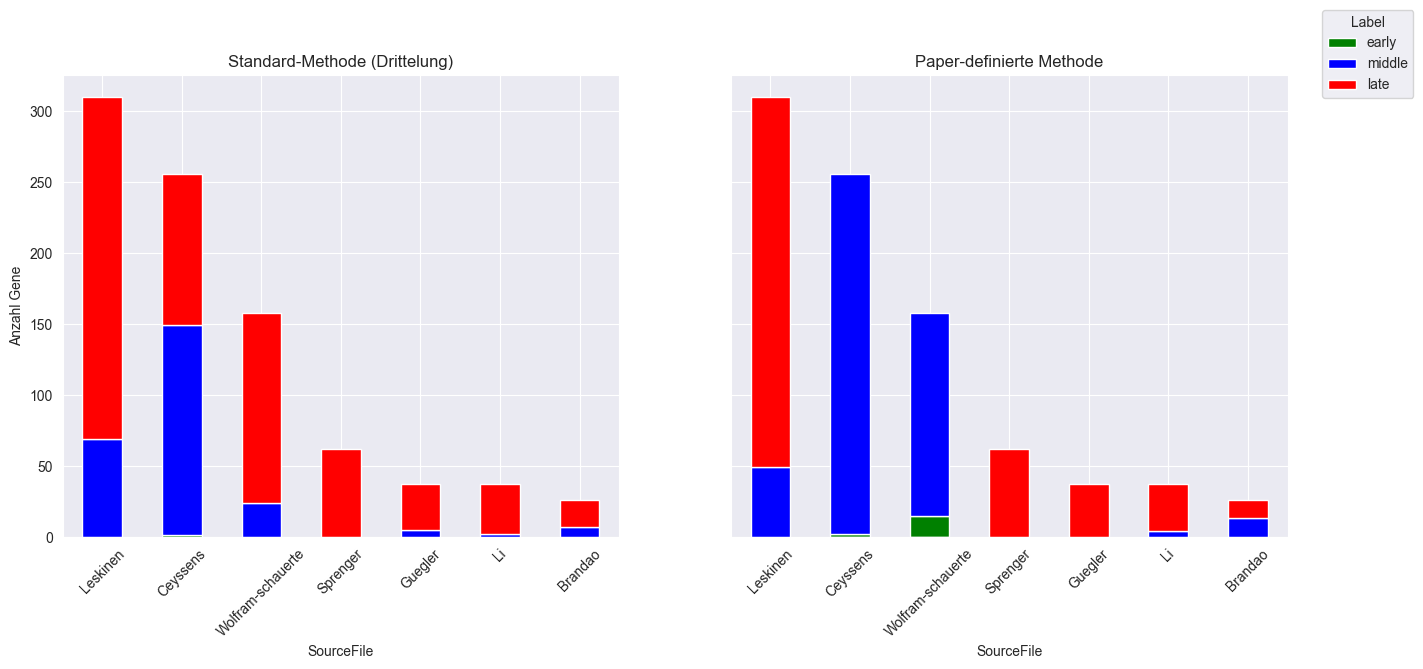

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# === Hilfsfunktion: Dateinamen auf kurze Papernamen reduzieren ===
def extract_paper_short_name(filename):
    """
    Ermittelt anhand des Dateinamens den zugehörigen Paper-Kurznamen.
    """
    papers = [
        "brandao", "ceyssens", "guegler", "leskinen",
        "li", "sprenger", "wolfram-schauerte"
    ]
    filename_lower = filename.lower()
    for paper in papers:
        if paper in filename_lower:
            return paper.capitalize()  # z.B. "Li", "Sprenger"
    return filename  # Falls kein Match, gib Originalname zurück

# === Gruppiere Gene pro Label und Datei für beide Methoden ===
label_counts_std = final_phage_genes.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)
label_counts_paper = final_phage_genes_paper_defined.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)

# === Gemeinsame Sortierung der Dateien nach Anzahl gelabelter Gene ===
label_order = ["early", "middle", "late"]
label_counts_std = label_counts_std.reindex(columns=label_order)
label_counts_paper = label_counts_paper.reindex(columns=label_order)
ordered_files = label_counts_std.sum(axis=1).sort_values(ascending=False).index
label_counts_std = label_counts_std.loc[ordered_files]
label_counts_paper = label_counts_paper.reindex(ordered_files).fillna(0)

# === Kürze die Dateinamen für X-Achse (z.B. „Li“, „Sprenger“) ===
short_labels = [extract_paper_short_name(f) for f in ordered_files]

# === Erstelle zwei nebeneinanderliegende Balkendiagramme ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

colors = {"early": "green", "middle": "blue", "late": "red"}
color_list = [colors[label] for label in label_order]

# Plot 1: Klassifikation mit Standard-Methode
label_counts_std.plot(
    kind='bar',
    stacked=True,
    color=color_list,
    ax=axes[0],
    legend=False
)
axes[0].set_title("Standard-Methode (Drittelung)")
axes[0].set_ylabel("Anzahl Gene")
axes[0].set_xticks(range(len(short_labels)))
axes[0].set_xticklabels(short_labels, rotation=45, fontsize=10)

# Plot 2: Klassifikation mit paper-definierter Methode
label_counts_paper.plot(
    kind='bar',
    stacked=True,
    color=color_list,
    ax=axes[1],
    legend=False
)
axes[1].set_title("Paper-definierte Methode")
axes[1].set_xticks(range(len(short_labels)))
axes[1].set_xticklabels(short_labels, rotation=45, fontsize=10)

# === Gemeinsame Legende außerhalb der Diagramme platzieren ===
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc='upper left')

# === Layout optimieren ===
plt.subplots_adjust(right=1)
plt.show()

## Ergebnisse der Klassifikation

### Standard-Methode
Bei der Standard-Methode wird nur ein einziges Gen als `early` klassifiziert, während die meisten Gene in die `late`-Phase fallen. Einige wenige Gene werden als `middle` klassifiziert. Besonders auffällig ist, dass der Datensatz Sprenger nur `late`-Gene enthält. Dies könnte darauf hindeuten, dass die meisten Gene in diesem Datensatz tatsächlich erst in späteren Phasen exprimiert werden, oder ein Fehler in der Klassifikation vorliegt.

### Paper-definierte Methode
Bei der paper-definierten Methode zeigt sich eine ausgewogenere Verteilung der Gene über die Phasen. Hier werden mehr Gene als `early` oder `middle` klassifiziert, was darauf hindeutet, dass die biologisch definierten Zeitfenster sinnvollere Ergebnisse liefern. Allerdings gibt es auch hier einige Datensätze, die vorwiegend `late`-Gene enthalten. Die Anzahl der `late` und `middle`Gene ist hier wesentlich ausgeglichener verteilt als bei der Standard-Methode. Wobei sehr auffällig ist, dass der Ceyssens Datensatz nun fast ausschließlich aus `middle` Genen besteht. Nichtdestotrotz sind wir uns bei der Klassifikation nicht sicher, ob die paper-definierte Methode tatsächlich genauer ist. 


# User Story 7: Visualisierung der aggregierten Klassenverteilung

In diesem Schritt werden die Ergebnisse der beiden Klassifikationsmethoden zusammengefasst und visualisiert. Hierfür nutzen wir für beide Methoden jeweils ein Kreisdiagramm und ein Balkendiagramm, um die Verteilung der Gene über die Phasen `early`, `middle` und `late` darzustellen.

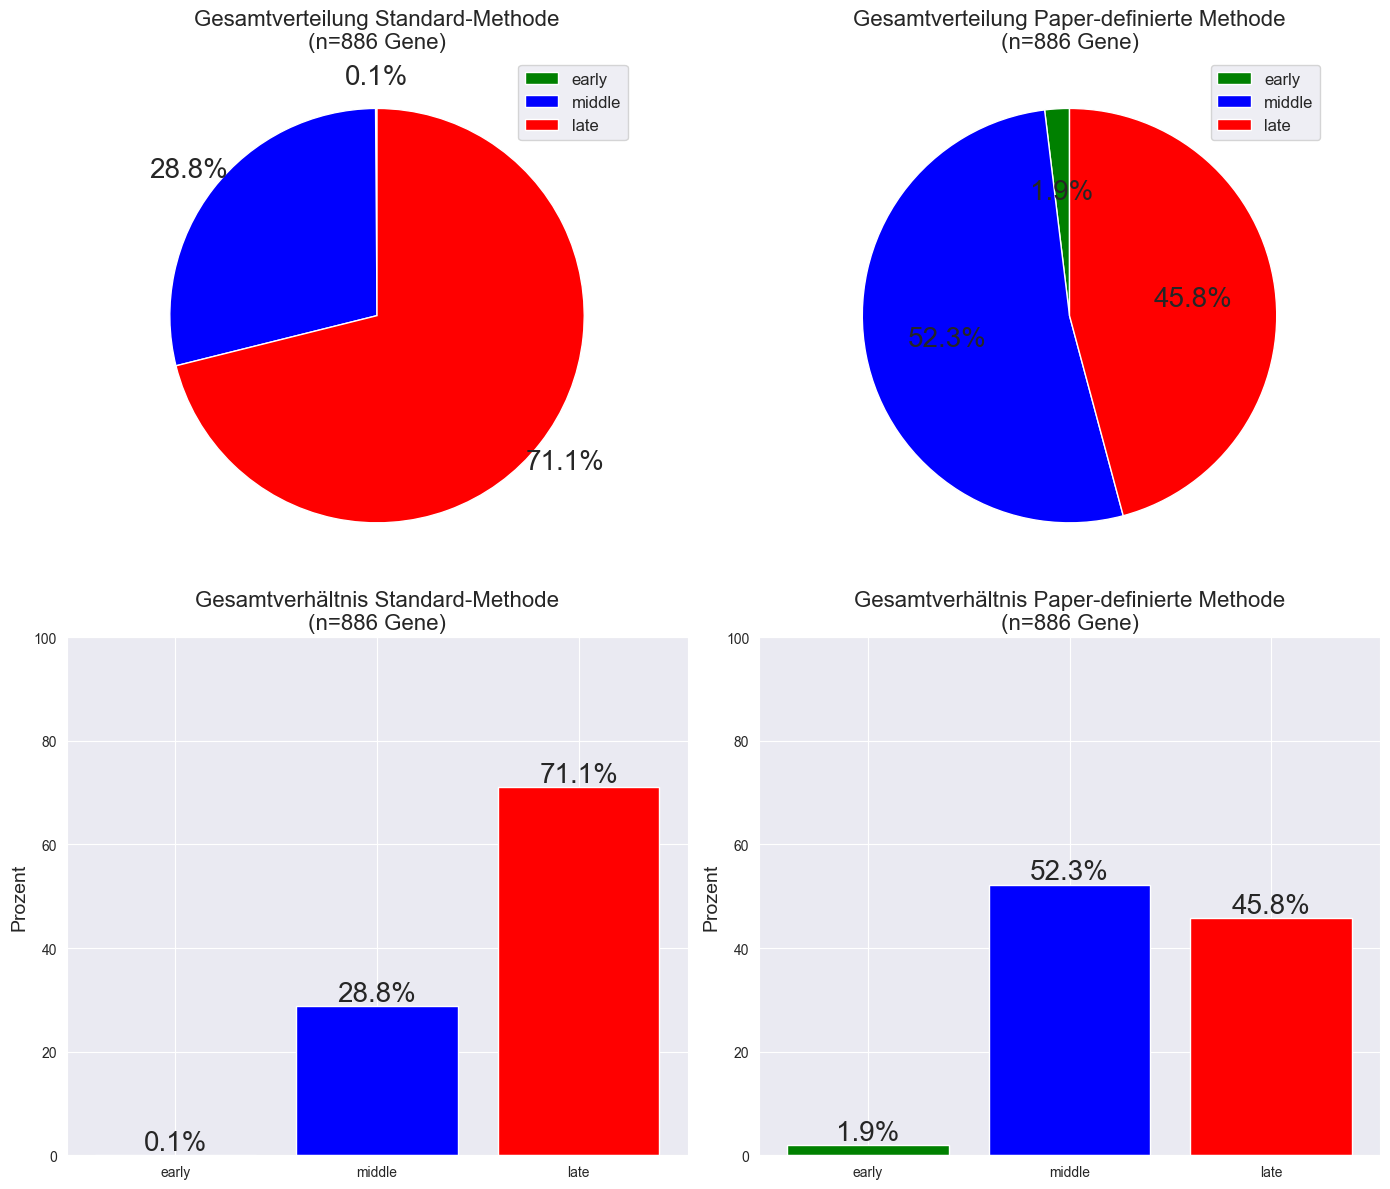

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

total_std = label_counts_std.sum()
total_paper = label_counts_paper.sum()

percent_std = total_std / total_std.sum() * 100
percent_paper = total_paper / total_paper.sum() * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Kreisdiagramme 
# Standard-Methode
axes[0, 0].pie(
    total_std,
    autopct='%1.1f%%',
    colors=color_list,
    startangle=90,
    textprops=dict(fontsize=20),
    pctdistance=1.15
)
axes[0, 0].set_title(
    f"Gesamtverteilung Standard-Methode\n(n={total_std.sum()} Gene)",
    fontsize=16
)
axes[0, 0].legend(label_order, loc="best", fontsize=12)

# Paper-definierte Methode
axes[0, 1].pie(
    total_paper,
    autopct='%1.1f%%',
    colors=color_list,
    startangle=90,
    textprops=dict(fontsize=20)
)
axes[0, 1].set_title(
    f"Gesamtverteilung Paper-definierte Methode\n(n={total_paper.sum()} Gene)",
    fontsize=16
)
axes[0, 1].legend(label_order, loc="best", fontsize=12)

# Balkendiagramme
# Standard-Methode
axes[1, 0].bar(label_order, percent_std, color=color_list)
axes[1, 0].set_title(
    f"Gesamtverhältnis Standard-Methode\n(n={total_std.sum()} Gene)",
    fontsize=16
)
axes[1, 0].set_ylabel("Prozent", fontsize=14)
axes[1, 0].set_ylim(0, 100)
for i, v in enumerate(percent_std):
    axes[1, 0].text(
        i, v + 1,
        f"{v:.1f}%",
        ha='center',
        fontsize=20
    )

# Paper-definierte Methode
axes[1, 1].bar(label_order, percent_paper, color=color_list)
axes[1, 1].set_title(
    f"Gesamtverhältnis Paper-definierte Methode\n(n={total_paper.sum()} Gene)",
    fontsize=16
)
axes[1, 1].set_ylabel("Prozent", fontsize=14)
axes[1, 1].set_ylim(0, 100)
for i, v in enumerate(percent_paper):
    axes[1, 1].text(
        i, v + 1,
        f"{v:.1f}%",
        ha='center',
        fontsize=20
    )

plt.tight_layout()
plt.show()


Bei der Analyse des Gesamtdatensatzes ist ersichtlich geworden, was bei der Einzelbetrachtung bereits zu erahnen war:
Wir haben bei beiden Labelingvarianten einen starken Late-Überhang und fast gar kein Early-Vorkommen.
Die an die jeweiligen Paper angepasste Methode performed tendenziell besser als die einfache Drittelung.